In [1]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [2]:
# -----------------------------------
# 1. Mount Google Drive
# -----------------------------------


from google.colab import drive
drive.mount('/content/drive')

BASE_DIR        = '/content/drive/MyDrive/retina project/DRIVE_unzipped/DRIVE'
TRAIN_IMG_DIR   = f"{BASE_DIR}/training/images"
TRAIN_MASK_DIR  = f"{BASE_DIR}/training/1st_manual"
TEST_IMG_DIR    = f"{BASE_DIR}/test/images"
TEST_MASK_DIR   = f"{BASE_DIR}/test/1st_manual"


Mounted at /content/drive


In [3]:
# -----------------------------------
# 2. Imports & Params
# -----------------------------------
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# image size & training params
IMG_SIZE   = 512
BATCH_SIZE = 4
EPOCHS     = 250

# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def load_images(folder, file_pattern, is_mask=False):
    imgs = []
    for fname in sorted(os.listdir(folder)):
        if file_pattern not in fname: continue
        if not fname.lower().endswith(('.png','.tif','.jpg')): continue
        path = os.path.join(folder, fname)
        img  = cv2.imread(path, cv2.IMREAD_COLOR if not is_mask else cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read {path}")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if not is_mask:
            g = img[:,:,1]
            g = clahe.apply(g)
            g = g.astype('float32')/255.0
            imgs.append(np.expand_dims(g, -1))
        else:
            m = img.astype('float32')/255.0
            imgs.append(np.expand_dims(m, -1))
    return np.array(imgs)

# load & split
X_train = load_images(TRAIN_IMG_DIR, '_training.png', is_mask=False)
y_train = load_images(TRAIN_MASK_DIR,  '_manual1.png', is_mask=True)
X_test  = load_images(TEST_IMG_DIR,  '_test.png',    is_mask=False)
y_test  = load_images(TEST_MASK_DIR, '_manual1.png', is_mask=True)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [4]:
# -----------------------------------
# 3. Build gUnet (U-Net + SE + Attention) — Fixed gating shapes
# -----------------------------------
from tensorflow.keras import layers, models

def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

def conv_block_se(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return se_block(x)

def attention_gate(x, g, inter_channels):
    """
    x: encoder feature map (HxW)
    g: decoder gating signal (HxW)
    """
    theta_x = layers.Conv2D(inter_channels, 1, padding='same')(x)
    phi_g   = layers.Conv2D(inter_channels, 1, padding='same')(g)
    add_xg  = layers.Add()([theta_x, phi_g])
    act     = layers.Activation('relu')(add_xg)
    psi     = layers.Conv2D(1, 1, padding='same')(act)
    psi     = layers.Activation('sigmoid')(psi)
    return layers.Multiply()([x, psi])

def g_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_shape)

    # ─── Encoder ──────────────────────────────
    x0 = conv_block_se(inputs,  64);  p0 = layers.MaxPool2D()(x0)
    x1 = conv_block_se(p0,     128);  p1 = layers.MaxPool2D()(x1)
    x2 = conv_block_se(p1,     256);  p2 = layers.MaxPool2D()(x2)
    x3 = conv_block_se(p2,     512);  p3 = layers.MaxPool2D()(x3)
    x4 = conv_block_se(p3,    1024)

    # ─── Decoder + Attention ──────────────────
    # Stage 1: from x4→x3 (32→64)
    g3  = layers.Conv2D(512, 1, padding='same')(x4)
    g3u = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(g3)  # 64×64
    a3  = attention_gate(x3, g3u, inter_channels=256)
    d3  = conv_block_se(layers.Concatenate()([g3u, a3]), 512)

    # Stage 2: from d3→x2 (64→128)
    g2  = layers.Conv2D(256, 1, padding='same')(d3)
    g2u = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(g2)  # 128×128
    a2  = attention_gate(x2, g2u, inter_channels=128)
    d2  = conv_block_se(layers.Concatenate()([g2u, a2]), 256)

    # Stage 3: from d2→x1 (128→256)
    g1  = layers.Conv2D(128, 1, padding='same')(d2)
    g1u = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(g1)  # 256×256
    a1  = attention_gate(x1, g1u, inter_channels=64)
    d1  = conv_block_se(layers.Concatenate()([g1u, a1]), 128)

    # Stage 4: from d1→x0 (256→512)
    g0  = layers.Conv2D(64, 1, padding='same')(d1)
    g0u = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(g0)  # 512×512
    a0  = attention_gate(x0, g0u, inter_channels=32)
    d0  = conv_block_se(layers.Concatenate()([g0u, a0]), 64)

    # ─── Output ────────────────────────────────
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d0)
    return models.Model(inputs, outputs)

# instantiate & compile
model = g_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      1,152 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 29,536,029 (112.67 MB)

 Trainable params: 29,524,253 (112.63 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [5]:
# -----------------------------------
# 4. Train
# -----------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="/content/drive/MyDrive/retina project/unet(3+)_best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb],
    verbose=2
)


Epoch 1/250

Epoch 1: val_loss improved from inf to 0.68650, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 80s - 20s/step - accuracy: 0.5453 - loss: 0.6900 - val_accuracy: 0.8746 - val_loss: 0.6865
Epoch 2/250

Epoch 2: val_loss did not improve from 0.68650
4/4 - 1s - 157ms/step - accuracy: 0.7807 - loss: 0.5867 - val_accuracy: 0.0811 - val_loss: 0.7462
Epoch 3/250

Epoch 3: val_loss did not improve from 0.68650
4/4 - 1s - 152ms/step - accuracy: 0.8683 - loss: 0.5298 - val_accuracy: 0.0550 - val_loss: 4.8666
Epoch 4/250

Epoch 4: val_loss did not improve from 0.68650
4/4 - 1s - 149ms/step - accuracy: 0.8799 - loss: 0.4959 - val_accuracy: 0.0570 - val_loss: 4.4115
Epoch 5/250

Epoch 5: val_loss did not improve from 0.68650
4/4 - 1s - 149ms/step - accuracy: 0.8907 - loss: 0.4750 - val_accuracy: 0.0575 - val_loss: 4.5254
Epoch 6/250

Epoch 6: val_loss did not improve from 0.68650
4/4 - 1s - 149ms/step - accuracy: 0.8886 - loss: 0.4468 - val_accuracy: 0.0569 - val_loss: 43.1674
Epoch 7/250

Epoch 7: val_loss did not improve from 0.68650
4/4 - 1s - 150ms/step - accuracy: 0.9084 - loss: 0.3

4/4 - 2s - 468ms/step - accuracy: 0.9154 - loss: 0.2563 - val_accuracy: 0.8707 - val_loss: 0.2915
Epoch 13/250

Epoch 13: val_loss did not improve from 0.29145
4/4 - 1s - 151ms/step - accuracy: 0.8611 - loss: 0.3410 - val_accuracy: 0.8746 - val_loss: 27.3050
Epoch 14/250

Epoch 14: val_loss did not improve from 0.29145
4/4 - 1s - 149ms/step - accuracy: 0.8912 - loss: 0.3166 - val_accuracy: 0.8616 - val_loss: 0.6278
Epoch 15/250

Epoch 15: val_loss did not improve from 0.29145
4/4 - 1s - 150ms/step - accuracy: 0.9067 - loss: 0.2666 - val_accuracy: 0.0787 - val_loss: 94.1188
Epoch 16/250

Epoch 16: val_loss did not improve from 0.29145
4/4 - 1s - 149ms/step - accuracy: 0.9130 - loss: 0.2256 - val_accuracy: 0.0569 - val_loss: 563.1561
Epoch 17/250

Epoch 17: val_loss did not improve from 0.29145
4/4 - 1s - 150ms/step - accuracy: 0.9016 - loss: 0.2412 - val_accuracy: 0.0758 - val_loss: 206.9933
Epoch 18/250

Epoch 18: val_loss did not improve from 0.29145
4/4 - 1s - 149ms/step - accuracy: 

4/4 - 2s - 495ms/step - accuracy: 0.9158 - loss: 0.1312 - val_accuracy: 0.8746 - val_loss: 0.2855
Epoch 43/250

Epoch 43: val_loss did not improve from 0.28547
4/4 - 1s - 149ms/step - accuracy: 0.9150 - loss: 0.1359 - val_accuracy: 0.8746 - val_loss: 0.4286
Epoch 44/250

Epoch 44: val_loss did not improve from 0.28547
4/4 - 1s - 149ms/step - accuracy: 0.9157 - loss: 0.1356 - val_accuracy: 0.8746 - val_loss: 0.5061
Epoch 45/250

Epoch 45: val_loss improved from 0.28547 to 0.27764, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 469ms/step - accuracy: 0.9148 - loss: 0.1325 - val_accuracy: 0.8746 - val_loss: 0.2776
Epoch 46/250

Epoch 46: val_loss improved from 0.27764 to 0.26555, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 691ms/step - accuracy: 0.9166 - loss: 0.1283 - val_accuracy: 0.8746 - val_loss: 0.2655
Epoch 47/250

Epoch 47: val_loss did not improve from 0.26555
4/4 - 1s - 155ms/step - accuracy: 0.9170 - loss: 0.1255 - val_accuracy: 0.1658 - val_loss: 3.8334
Epoch 48/250

Epoch 48: val_loss did not improve from 0.26555
4/4 - 1s - 149ms/step - accuracy: 0.9179 - loss: 0.1221 - val_accuracy: 0.8748 - val_loss: 0.3272
Epoch 49/250

Epoch 49: val_loss did not improve from 0.26555
4/4 - 1s - 149ms/step - accuracy: 0.9144 - loss: 0.1313 - val_accuracy: 0.8746 - val_loss: 0.6823
Epoch 50/250

Epoch 50: val_loss did not improve from 0.26555
4/4 - 1s - 149ms/step - accuracy: 0.9166 - loss: 0.1238 - val_accuracy: 0.3025 - val_loss: 1.5055
Epoch 51/250

Epoch 51: val_loss did not improve from 0.26555
4/4 - 1s - 150ms/step - accuracy: 0.9167 - loss: 0.1255 - val_accuracy: 0.8746 - val_loss: 0.4416
Epoch 52/250

Epoch 52: val_loss did not improve from 0.26555
4/4 - 1s - 151ms/step - accuracy: 0.9151

4/4 - 2s - 470ms/step - accuracy: 0.9146 - loss: 0.1314 - val_accuracy: 0.8746 - val_loss: 0.2613
Epoch 59/250

Epoch 59: val_loss did not improve from 0.26127
4/4 - 1s - 149ms/step - accuracy: 0.9148 - loss: 0.1299 - val_accuracy: 0.2287 - val_loss: 4.1258
Epoch 60/250

Epoch 60: val_loss did not improve from 0.26127
4/4 - 1s - 149ms/step - accuracy: 0.9165 - loss: 0.1267 - val_accuracy: 0.3149 - val_loss: 1.9700
Epoch 61/250

Epoch 61: val_loss did not improve from 0.26127
4/4 - 1s - 149ms/step - accuracy: 0.9157 - loss: 0.1276 - val_accuracy: 0.8757 - val_loss: 0.3152
Epoch 62/250

Epoch 62: val_loss did not improve from 0.26127
4/4 - 1s - 149ms/step - accuracy: 0.9158 - loss: 0.1266 - val_accuracy: 0.8760 - val_loss: 0.3341
Epoch 63/250

Epoch 63: val_loss did not improve from 0.26127
4/4 - 1s - 149ms/step - accuracy: 0.9170 - loss: 0.1221 - val_accuracy: 0.8746 - val_loss: 0.3790
Epoch 64/250

Epoch 64: val_loss did not improve from 0.26127
4/4 - 1s - 149ms/step - accuracy: 0.9168

4/4 - 8s - 2s/step - accuracy: 0.9205 - loss: 0.1048 - val_accuracy: 0.8786 - val_loss: 0.2497
Epoch 138/250

Epoch 138: val_loss did not improve from 0.24966
4/4 - 1s - 159ms/step - accuracy: 0.9203 - loss: 0.1052 - val_accuracy: 0.8810 - val_loss: 0.2531
Epoch 139/250

Epoch 139: val_loss improved from 0.24966 to 0.24473, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 473ms/step - accuracy: 0.9210 - loss: 0.1037 - val_accuracy: 0.8795 - val_loss: 0.2447
Epoch 140/250

Epoch 140: val_loss did not improve from 0.24473
4/4 - 1s - 150ms/step - accuracy: 0.9208 - loss: 0.1041 - val_accuracy: 0.8803 - val_loss: 0.2489
Epoch 141/250

Epoch 141: val_loss improved from 0.24473 to 0.23567, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 472ms/step - accuracy: 0.9212 - loss: 0.1028 - val_accuracy: 0.8817 - val_loss: 0.2357
Epoch 142/250

Epoch 142: val_loss improved from 0.23567 to 0.23545, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 468ms/step - accuracy: 0.9206 - loss: 0.1038 - val_accuracy: 0.8811 - val_loss: 0.2355
Epoch 143/250

Epoch 143: val_loss improved from 0.23545 to 0.22988, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 467ms/step - accuracy: 0.9212 - loss: 0.1030 - val_accuracy: 0.8830 - val_loss: 0.2299
Epoch 144/250

Epoch 144: val_loss improved from 0.22988 to 0.20775, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 473ms/step - accuracy: 0.9214 - loss: 0.1023 - val_accuracy: 0.8835 - val_loss: 0.2078
Epoch 145/250

Epoch 145: val_loss did not improve from 0.20775
4/4 - 1s - 149ms/step - accuracy: 0.9211 - loss: 0.1026 - val_accuracy: 0.8813 - val_loss: 0.2244
Epoch 146/250

Epoch 146: val_loss did not improve from 0.20775
4/4 - 1s - 149ms/step - accuracy: 0.9212 - loss: 0.1022 - val_accuracy: 0.8818 - val_loss: 0.2081
Epoch 147/250

Epoch 147: val_loss did not improve from 0.20775
4/4 - 1s - 149ms/step - accuracy: 0.9212 - loss: 0.1027 - val_accuracy: 0.8838 - val_loss: 0.2322
Epoch 148/250

Epoch 148: val_loss improved from 0.20775 to 0.20596, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 468ms/step - accuracy: 0.9214 - loss: 0.1023 - val_accuracy: 0.8851 - val_loss: 0.2060
Epoch 149/250

Epoch 149: val_loss did not improve from 0.20596
4/4 - 1s - 149ms/step - accuracy: 0.9209 - loss: 0.1047 - val_accuracy: 0.8838 - val_loss: 0.2491
Epoch 150/250

Epoch 150: val_loss improved from 0.20596 to 0.16744, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 604ms/step - accuracy: 0.9197 - loss: 0.1097 - val_accuracy: 0.8977 - val_loss: 0.1674
Epoch 151/250

Epoch 151: val_loss did not improve from 0.16744
4/4 - 1s - 154ms/step - accuracy: 0.9169 - loss: 0.1171 - val_accuracy: 0.4014 - val_loss: 0.8564
Epoch 152/250

Epoch 152: val_loss did not improve from 0.16744
4/4 - 1s - 150ms/step - accuracy: 0.9154 - loss: 0.1242 - val_accuracy: 0.8611 - val_loss: 0.3315
Epoch 153/250

Epoch 153: val_loss did not improve from 0.16744
4/4 - 1s - 150ms/step - accuracy: 0.9161 - loss: 0.1219 - val_accuracy: 0.8637 - val_loss: 1.0868
Epoch 154/250

Epoch 154: val_loss did not improve from 0.16744
4/4 - 1s - 148ms/step - accuracy: 0.9165 - loss: 0.1214 - val_accuracy: 0.8573 - val_loss: 1.0705
Epoch 155/250

Epoch 155: val_loss did not improve from 0.16744
4/4 - 1s - 148ms/step - accuracy: 0.9172 - loss: 0.1185 - val_accuracy: 0.8562 - val_loss: 1.2924
Epoch 156/250

Epoch 156: val_loss did not improve from 0.16744
4/4 - 1s - 149ms/step - accu

4/4 - 6s - 2s/step - accuracy: 0.9200 - loss: 0.1075 - val_accuracy: 0.9061 - val_loss: 0.1614
Epoch 229/250

Epoch 229: val_loss did not improve from 0.16136
4/4 - 1s - 154ms/step - accuracy: 0.9195 - loss: 0.1095 - val_accuracy: 0.8829 - val_loss: 0.2206
Epoch 230/250

Epoch 230: val_loss did not improve from 0.16136
4/4 - 1s - 148ms/step - accuracy: 0.9192 - loss: 0.1091 - val_accuracy: 0.8946 - val_loss: 0.2009
Epoch 231/250

Epoch 231: val_loss did not improve from 0.16136
4/4 - 1s - 149ms/step - accuracy: 0.9200 - loss: 0.1073 - val_accuracy: 0.8702 - val_loss: 0.2222
Epoch 232/250

Epoch 232: val_loss did not improve from 0.16136
4/4 - 1s - 149ms/step - accuracy: 0.9206 - loss: 0.1060 - val_accuracy: 0.7606 - val_loss: 0.4536
Epoch 233/250

Epoch 233: val_loss did not improve from 0.16136
4/4 - 1s - 149ms/step - accuracy: 0.9205 - loss: 0.1061 - val_accuracy: 0.7910 - val_loss: 0.3553
Epoch 234/250

Epoch 234: val_loss did not improve from 0.16136
4/4 - 1s - 149ms/step - accurac

4/4 - 2s - 466ms/step - accuracy: 0.9202 - loss: 0.1063 - val_accuracy: 0.9078 - val_loss: 0.1408
Epoch 239/250

Epoch 239: val_loss did not improve from 0.14078
4/4 - 1s - 149ms/step - accuracy: 0.9207 - loss: 0.1054 - val_accuracy: 0.9013 - val_loss: 0.1690
Epoch 240/250

Epoch 240: val_loss did not improve from 0.14078
4/4 - 1s - 149ms/step - accuracy: 0.9209 - loss: 0.1043 - val_accuracy: 0.9046 - val_loss: 0.1681
Epoch 241/250

Epoch 241: val_loss improved from 0.14078 to 0.12945, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 462ms/step - accuracy: 0.9204 - loss: 0.1058 - val_accuracy: 0.9108 - val_loss: 0.1294
Epoch 242/250

Epoch 242: val_loss did not improve from 0.12945
4/4 - 1s - 149ms/step - accuracy: 0.9199 - loss: 0.1062 - val_accuracy: 0.9054 - val_loss: 0.1361
Epoch 243/250

Epoch 243: val_loss did not improve from 0.12945
4/4 - 1s - 149ms/step - accuracy: 0.9203 - loss: 0.1065 - val_accuracy: 0.9104 - val_loss: 0.1328
Epoch 244/250

Epoch 244: val_loss improved from 0.12945 to 0.12318, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 468ms/step - accuracy: 0.9203 - loss: 0.1056 - val_accuracy: 0.9138 - val_loss: 0.1232
Epoch 245/250

Epoch 245: val_loss did not improve from 0.12318
4/4 - 1s - 150ms/step - accuracy: 0.9206 - loss: 0.1052 - val_accuracy: 0.9108 - val_loss: 0.1291
Epoch 246/250

Epoch 246: val_loss did not improve from 0.12318
4/4 - 1s - 150ms/step - accuracy: 0.9206 - loss: 0.1053 - val_accuracy: 0.9092 - val_loss: 0.1305
Epoch 247/250

Epoch 247: val_loss improved from 0.12318 to 0.12072, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 2s - 468ms/step - accuracy: 0.9210 - loss: 0.1044 - val_accuracy: 0.9120 - val_loss: 0.1207
Epoch 248/250

Epoch 248: val_loss did not improve from 0.12072
4/4 - 1s - 149ms/step - accuracy: 0.9205 - loss: 0.1051 - val_accuracy: 0.9114 - val_loss: 0.1283
Epoch 249/250

Epoch 249: val_loss did not improve from 0.12072
4/4 - 1s - 151ms/step - accuracy: 0.9211 - loss: 0.1040 - val_accuracy: 0.9094 - val_loss: 0.1265
Epoch 250/250

Epoch 250: val_loss did not improve from 0.12072
4/4 - 1s - 149ms/step - accuracy: 0.9209 - loss: 0.1043 - val_accuracy: 0.9105 - val_loss: 0.1255


In [7]:
# -----------------------------------
# 5. Load & Predict with best gUnet
# -----------------------------------
from tensorflow.keras.models import load_model
import numpy as np

# 1) Load the best saved model
model = load_model("/content/drive/MyDrive/retina project/best_model(gUnet).h5")

# 2) Run prediction on the test set (batch_size=1 to avoid OOM)
preds     = model.predict(X_test, batch_size=1)
preds_bin = (preds > 0.5).astype(np.uint8)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


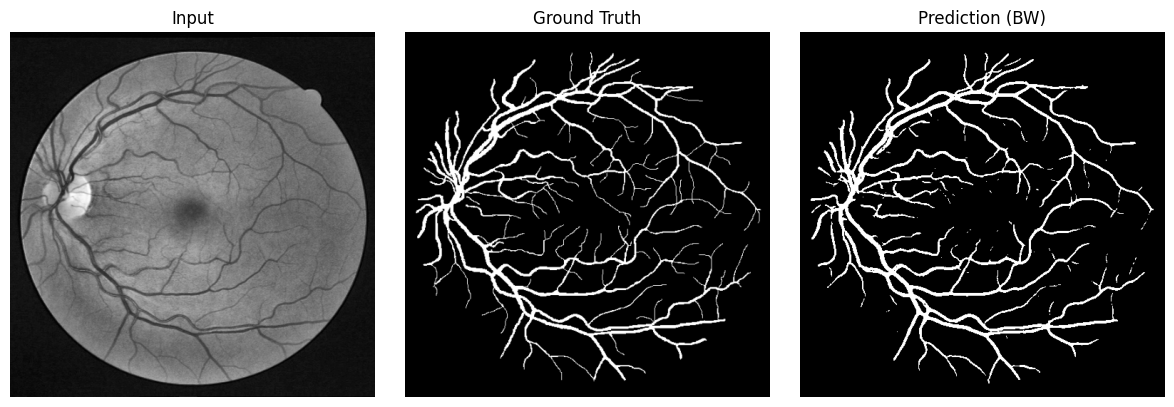

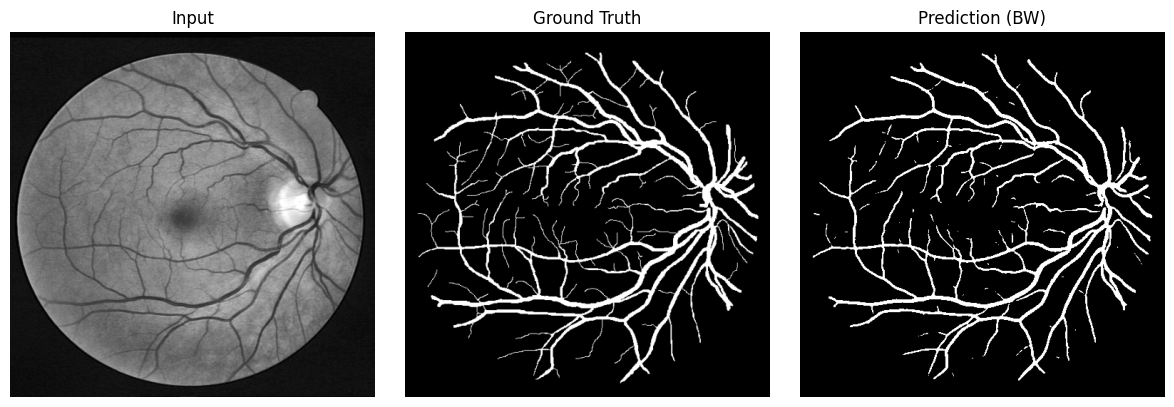

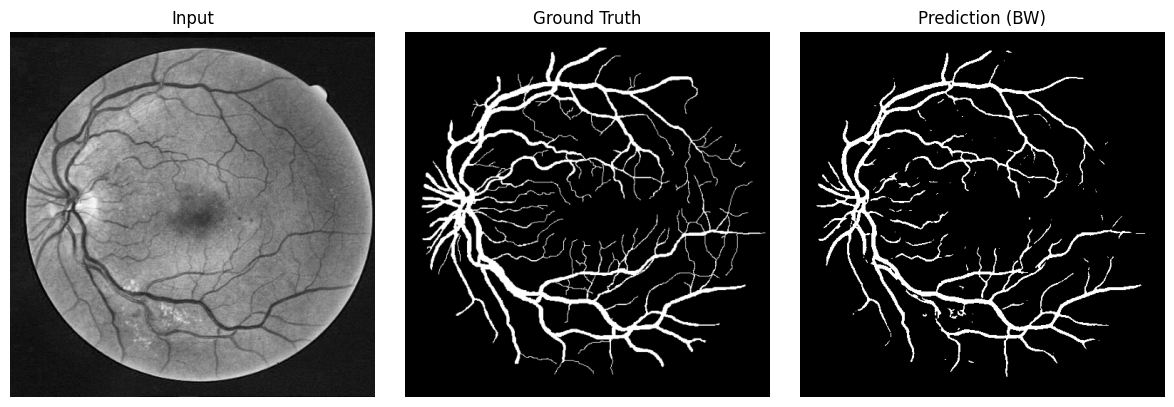

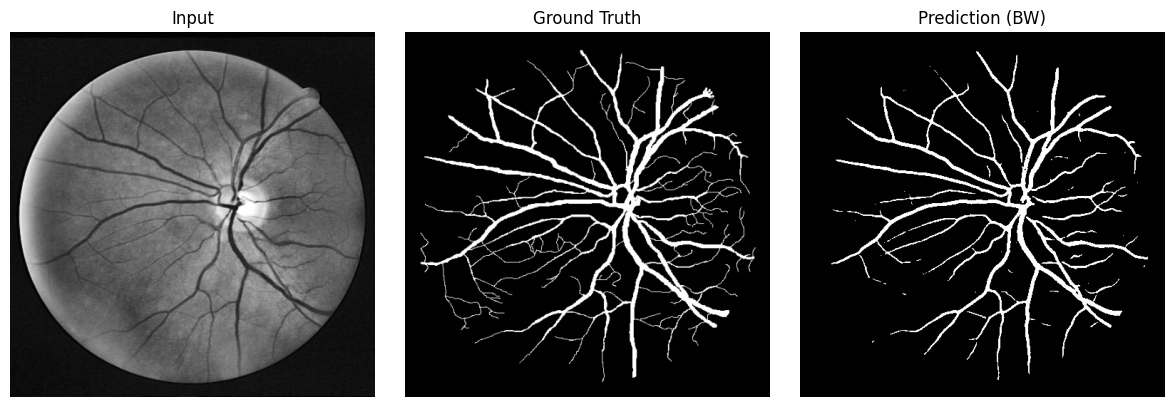

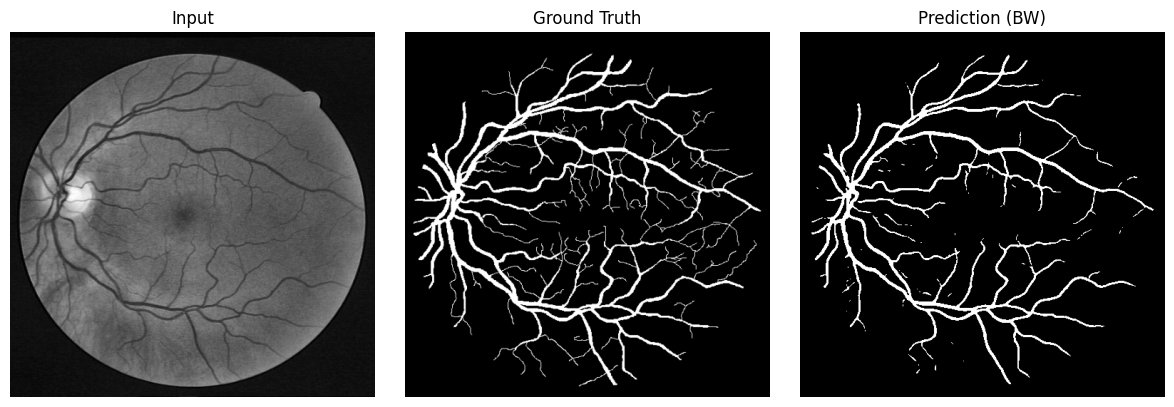

In [8]:
# -----------------------------------
# 6. Visualize Predictions
# -----------------------------------
import matplotlib.pyplot as plt

def display_results(i):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    # Input image
    axs[0].imshow(X_test[i].squeeze(), cmap='gray')
    axs[0].set_title("Input")
    axs[0].axis("off")
    # Ground truth mask
    axs[1].imshow(y_test[i].squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")
    # Predicted mask (binary)
    axs[2].imshow(preds_bin[i].squeeze(), cmap='gray')
    axs[2].set_title("Prediction (BW)")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()

# Display the first 5 test examples
for i in range(5):
    display_results(i)


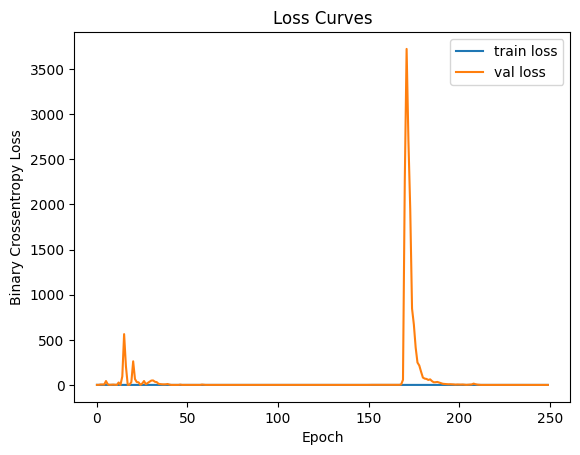

In [9]:
# -----------------------------------
# 7. Plot Training & Validation Loss
# -----------------------------------
import matplotlib.pyplot as plt

# assume `history` is the History object from model.fit
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()


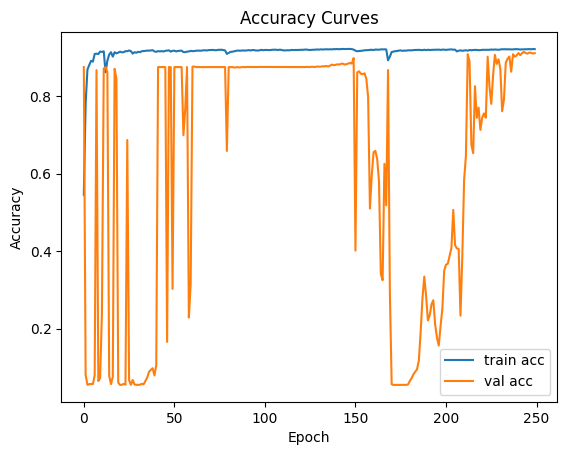

In [10]:
# -----------------------------------
# 8. Plot Training & Validation Accuracy
# -----------------------------------
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
